In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorCVAE, for NeurIPS


In [6]:
import jax.numpy as jnp
# Numpyro

from jax.config import config
config.update("jax_disable_jit", False)

from jax import random
from numpyro.infer import Predictive

from reusable.gp import OneDGP_UnifLS
from reusable.kernels import esq_kernel

from reusable.util import (load_args, load_samples, load_training_history, load_training_state, get_decoder_params, gen_file_name)



In [7]:
args = load_args("14", "args_v4")



### Examples of priors to encode

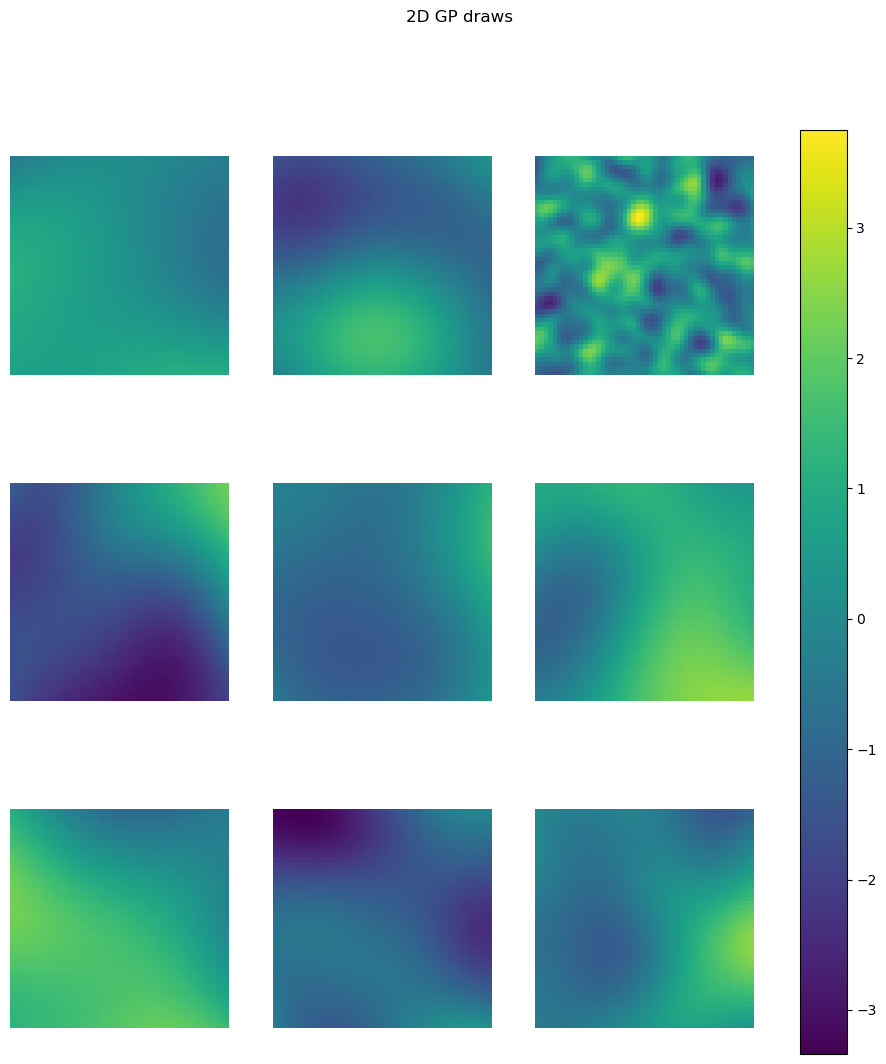

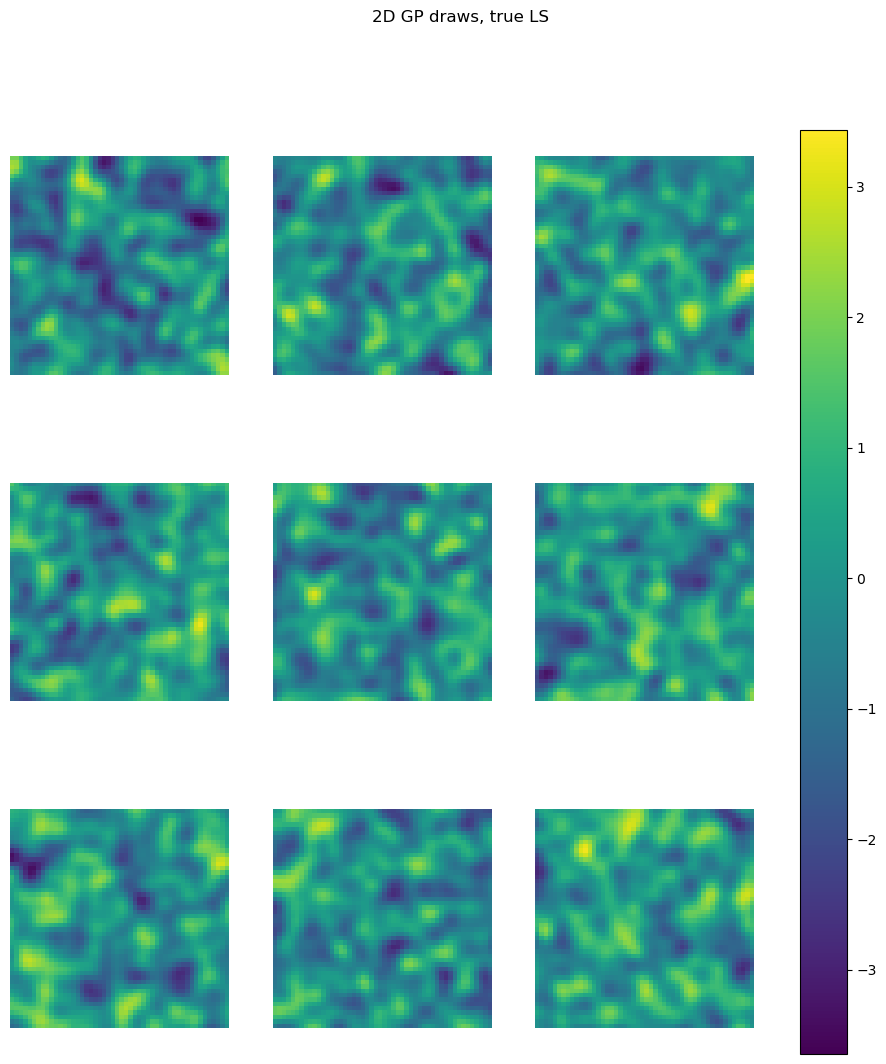

In [8]:
from plotting.plots import plot_2d_draws

rng_key_plots =  random.PRNGKey(5)

to_plot = 9

plot_pred = Predictive(OneDGP_UnifLS, num_samples=to_plot)
all_gp_plot_samples = plot_pred(rng_key_plots, x=args["x"], gp_kernel=args["gp_kernel"], jitter=5e-5)["y"]

plot_2d_draws(all_gp_plot_samples.reshape(-1, *([args["n"]] * args["dim"])), to_plot, 3, "2D GP draws")

true_gp_plot_samples = plot_pred(rng_key_plots, x=args["x"], gp_kernel=args["gp_kernel"], jitter=5e-5, length=0.05)["y"]

plot_2d_draws(true_gp_plot_samples.reshape(-1, *([args["n"]] * args["dim"])), to_plot, 3, "2D GP draws, true LS")


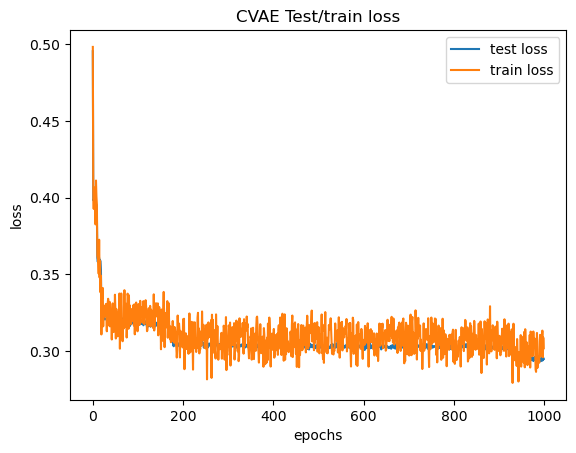

In [9]:
from plotting.plots import plot_training
from reusable.util import load_training_history, gen_file_name

metrics_history = load_training_history("14", gen_file_name("14", args))

plot_training(metrics_history["test_loss"], metrics_history["train_loss"], "CVAE Test/train loss", note="loss")


### Training progress

In [10]:
from flax.core.frozen_dict import freeze
from flax import serialization
from reusable.util import get_decoder_params, load_training_state, gen_file_name
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key = random.PRNGKey(4)

rng_key, rng_key_init, rng_key_init_state = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"] ** args["dim"],
    conditional=True,
)
params = module.init(rng_key_init, jnp.ones((args["batch_size"], args["n"] ** args["dim"] + 1,)))[
    "params"
]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init_state)

args["decoder_params"] = get_decoder_params(load_training_state("14", gen_file_name("14", args), state))


## Demonstrations

None
None


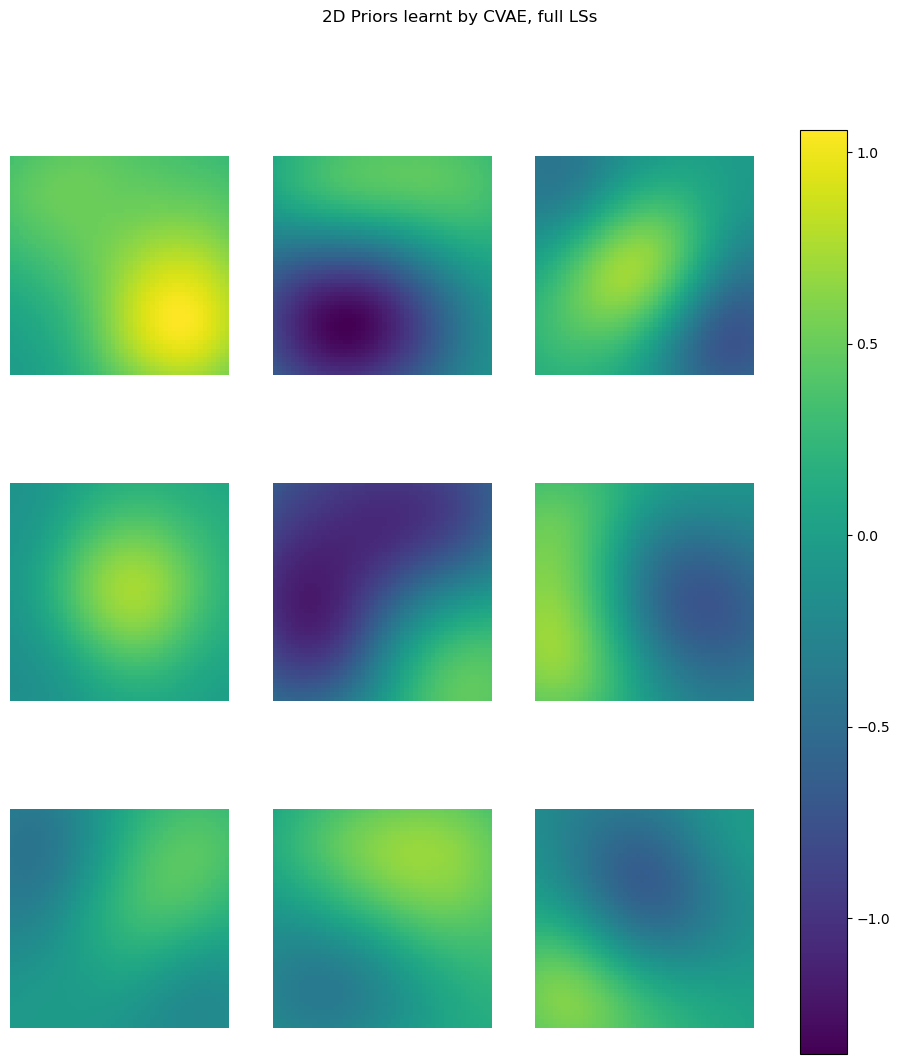

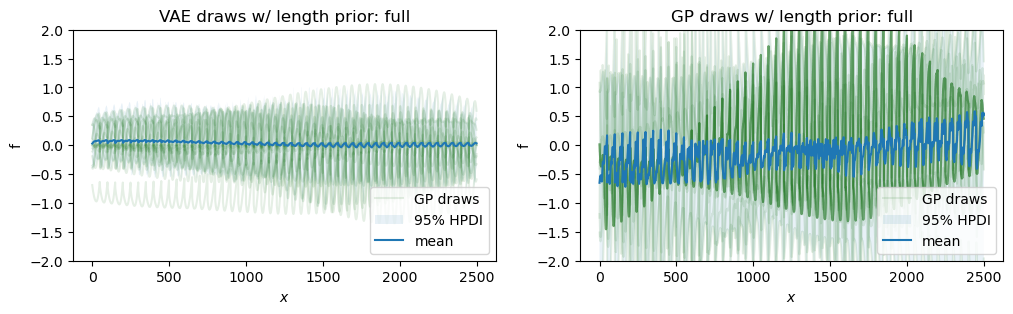

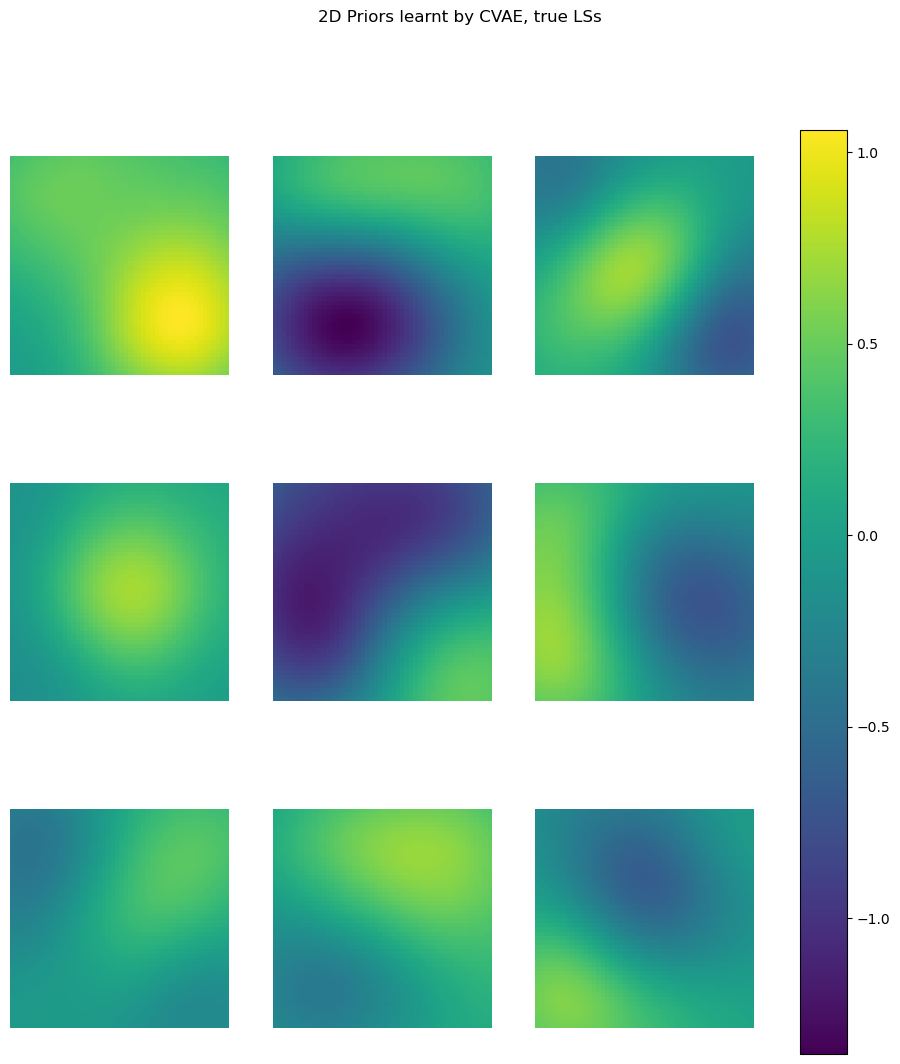

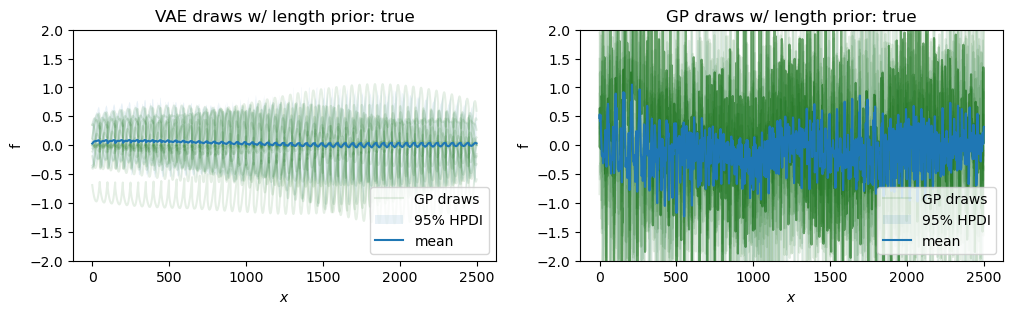

In [20]:
from reusable.mcmc import cvae_length_mcmc
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

conditions = [(None, "full", all_gp_plot_samples), (0.05, "true", true_gp_plot_samples),]

cvae = cvae_length_mcmc(args["hidden_dim1"], args["hidden_dim2"], args["latent_dim"], args["decoder_params"], "uniform")


plot_vae_predictive = Predictive(cvae, num_samples=40)

for cond, label, dr in conditions:

   
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        x = args["x"],
        condition=cond
    )["f"]
    plot_2d_draws(jnp.reshape(vae_draws, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D Priors learnt by CVAE, {label} LSs")
    compare_draws(jnp.arange(args["n"] ** args["dim"]), vae_draws, dr, f"VAE draws w/ length prior: {label}", f"GP draws w/ length prior: {label}", "f", "f")


# Inference

Ground truth - true ls = 0.05

2500 1750
(2500,) [ True  True  True ... False False False]
[False  True  True ... False  True  True]
1750
1750


(-2.991621494293213, 2.9665367603302)

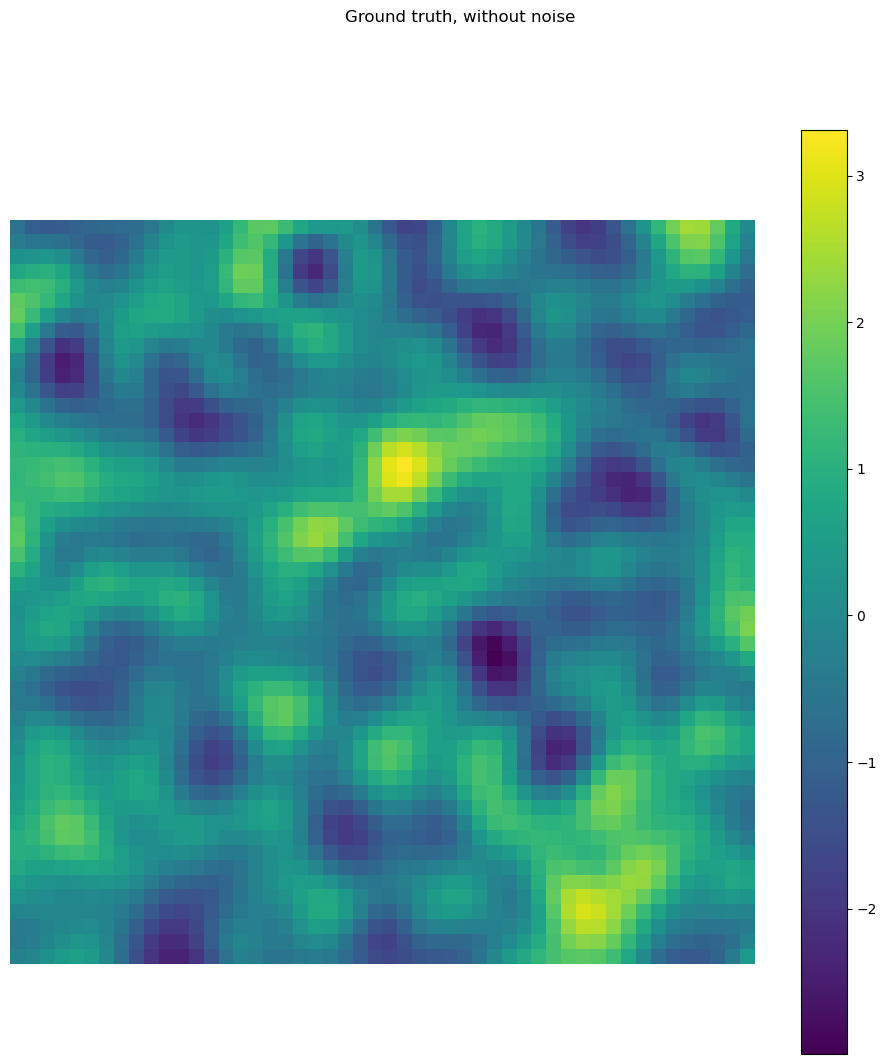

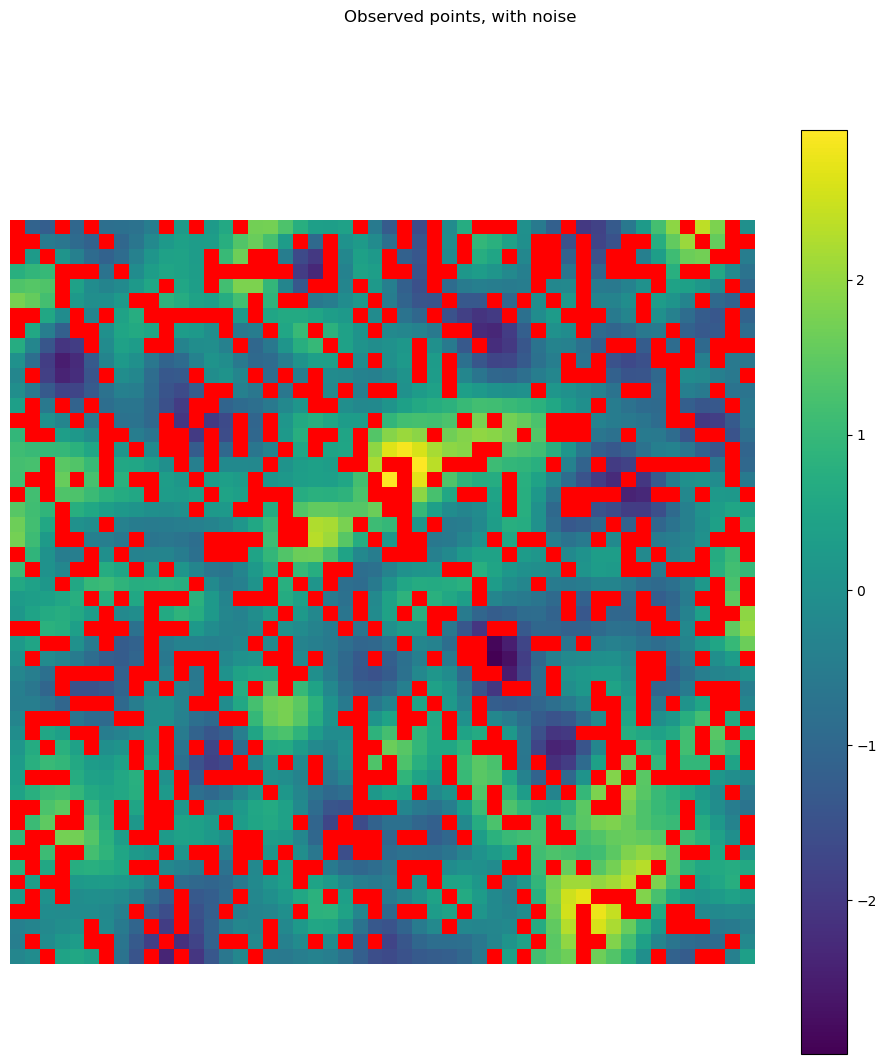

In [36]:
from reusable.gp import OneDGP_UnifLS
from plotting.plots import plot_2d_one_draw

# fixed to generate a "ground truth" GP we will try and infer
rng_key_ground_truth = random.PRNGKey(     4)  
rng_key_ground_truth, rng_key_ground_truth_obs_mask = random.split(rng_key_ground_truth, 2)

ground_truth_predictive = Predictive(OneDGP_UnifLS, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, noise=True, length=0.05
)
ground_truth = gt_draws["f"][0]
ground_truth_y_draw = gt_draws["y"][0]

n = args["n"] ** args["dim"]
num_obs = int(n * 0.7)
print(n, num_obs)

obs_mask = jnp.concatenate((jnp.full((num_obs), True), jnp.full((n-num_obs), False)))
print(obs_mask.shape, obs_mask)
obs_mask = random.permutation(rng_key_ground_truth_obs_mask, obs_mask)
print(obs_mask)

obs_idx = [x for x in range(n) if obs_mask[x]==True]
print(len(obs_idx))
obs_idx = jnp.array(obs_idx)

# obs_idx = jnp.array([2,7,24,28,33,34,37,48,49,55,61,69,71,75,84,102,103,115,116,123,141,145,157,185,187,188,193,197,208,227,228,229,233,235,260,271,280,290,304,316,317,321,331,343,346,349,352,358,368,369,372,378,380,390,394,408,424,442,450,452,454,462,483,489,511,518,522,524,548,551,555,560,565,566,567,580,582,593,601,611,613,616,618,619,645,651,654,655,656,665,666,676,690,695,709,729,732,744,749,767,794,796,813,815,841,843,844,845,852,863,866,870,872,877,878,883,901,902,904,909,923,932,944,947,948,949,966,967,974,982,993,994,996,998,1009,1018,1039,1052,1055,1058,1060,1062,1064,1067,1069,1070,1076,1109,1110,1112,1119,1120,1147,1156,1166,1182,1187,1194,1197,1198,1199,1202,1210,1223,1239,1265,1266,1280,1285,1289,1295,1301,1304,1305,1309,1325,1335,1342,1363,1370,1374,1378,1382,1402,1407,1410,1414,1453,1493,1504,1507,1516,1525,1539,1540,1541,1542,1550,1556,1565,1572,1576,1577,1582,1597,1599,1601,1607,1631,1632,1635,1640,1656,1667,1670,1680,1685,1697,1709,1715,1718,1741,1748,1757,1758,1764,1768,1770,1781,1790,1794,1816,1817,1825,1826,1841,1849,1869,1873,1884,1886,1894,1896,1905,1930,1936,1943,1948,1965,1973,1979,1984,1987,1989,2022,2025,2028,2052,2058,2079,2102,2103,2104,2129,2133,2135,2136,2141,2151,2152,2159,2161,2166,2179,2208,2235,2238,2239,2243,2270,2290,2293,2301,2304,2318,2322,2357,2363,2364,2370,2380,2389,2392,2413,2414,2425,2442,2443,2482,2499]) # indexing into flattened array
# obs_mask = jnp.isin(jnp.arange(0, args["n"] **args["dim"]), obs_idx, assume_unique=True)
print(obs_mask.sum())

ground_truth_y_obs = ground_truth_y_draw[obs_idx]
x_obs = jnp.arange(0, args["n"] **args["dim"])[obs_idx]


vmin, vmax = plot_2d_one_draw(ground_truth.reshape(([args["n"]] * args["dim"])), "Ground truth, without noise")
plot_2d_one_draw(ground_truth.reshape(([args["n"]] * args["dim"])), "Observed points, with noise", vmin=vmin, vmax=vmax, mask=~obs_mask )


## Inference: assume correct LS

/home/max/4yp/reusable/mcmc.py:107: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


0.05
0.05
0.05


  0%|          | 0/8000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>


sample: 100%|██████████| 8000/8000 [00:12<00:00, 645.30it/s, 15 steps of size 2.37e-01. acc. prob=0.86]


Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
0.05
0.05
0.05


sample: 100%|██████████| 8000/8000 [00:08<00:00, 924.57it/s, 15 steps of size 2.51e-01. acc. prob=0.84]


0.05
0.05
0.05


sample: 100%|██████████| 8000/8000 [00:09<00:00, 836.42it/s, 15 steps of size 2.33e-01. acc. prob=0.87]



MCMC elapsed time: 34.0561363697052
None


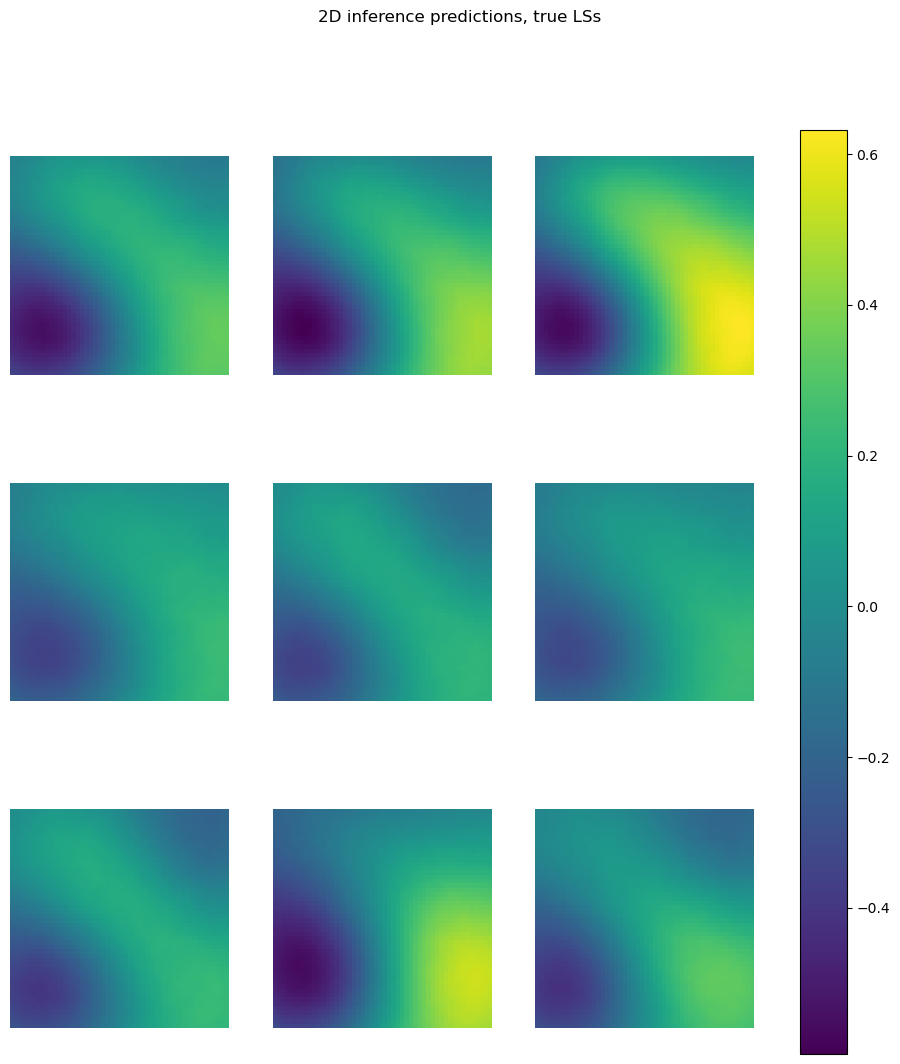

In [13]:
from reusable.util import load_samples
from reusable.mcmc import run_mcmc
import numpyro
numpyro.set_host_device_count(3)
rng_key, rng_key_all_mcmc, rng_key_true_mcmc = random.split(rng_key, 3)
rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)


true_ls_cvae_mcmc_samples = run_mcmc(args["num_warmup"], args["num_samples"], args["num_chains"], rng_key_true_mcmc, cvae, args["x"], ground_truth_y_obs, obs_idx, condition=0.05)


predictive = Predictive(cvae, true_ls_cvae_mcmc_samples)

predictions = predictive(rng_key_pred, x=args["x"], length=None)["f"]


plot_2d_draws(jnp.reshape(predictions, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D inference predictions, true LSs")


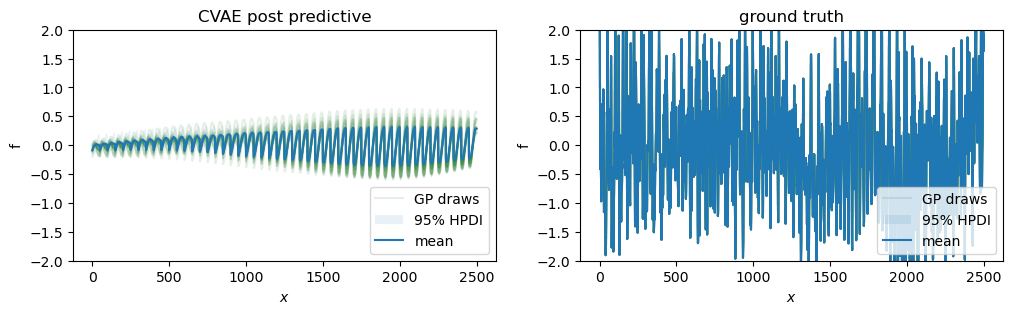

In [14]:

compare_draws(jnp.arange(args["n"] ** args["dim"]), predictions, ground_truth_y_draw[None], "CVAE post predictive", "ground truth", "f", "f")

## Inference: assume no LS

/home/max/4yp/reusable/mcmc.py:109: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(


None
None
None


  0%|          | 0/8000 [00:00<?, ?it/s]

None


sample: 100%|██████████| 8000/8000 [00:28<00:00, 275.96it/s, 127 steps of size 2.94e-02. acc. prob=0.87]


None
None
None
None


sample: 100%|██████████| 8000/8000 [00:20<00:00, 384.63it/s, 63 steps of size 6.23e-02. acc. prob=0.69]  


None
None
None


sample: 100%|██████████| 8000/8000 [00:18<00:00, 428.60it/s, 63 steps of size 5.48e-02. acc. prob=0.74] 



MCMC elapsed time: 69.89568519592285
None


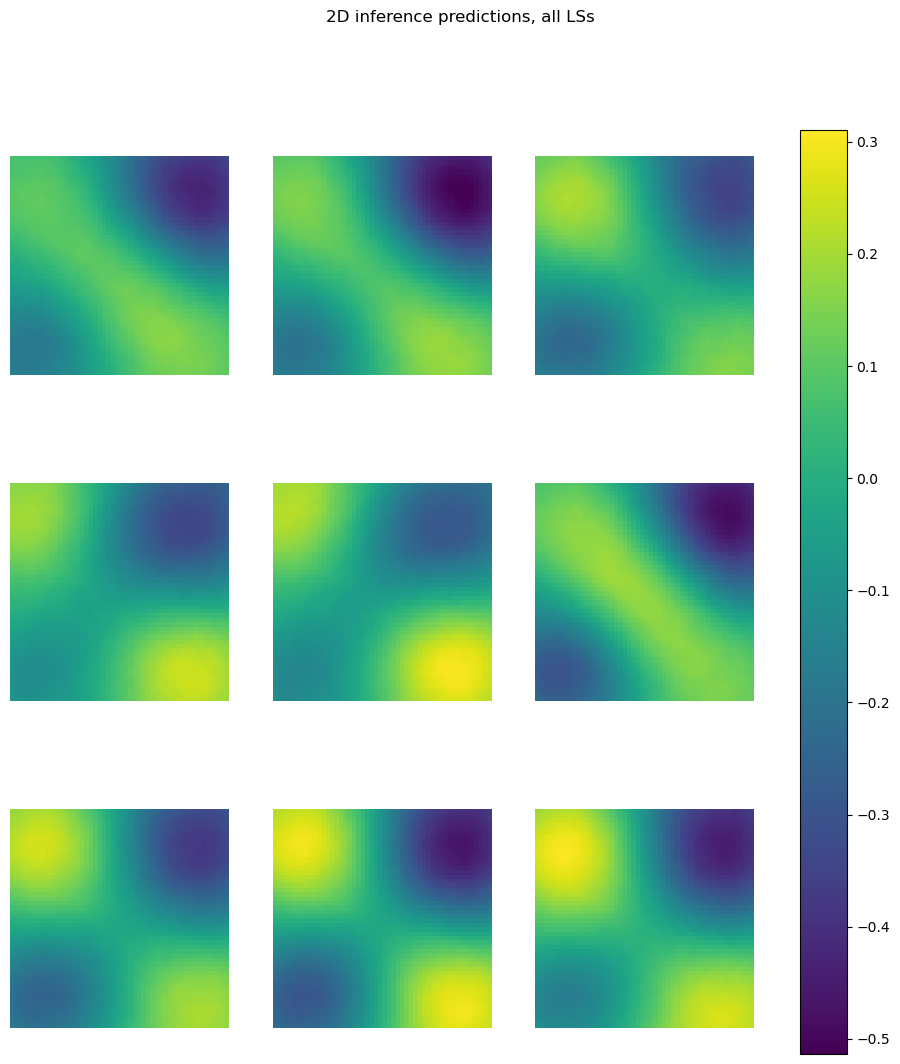

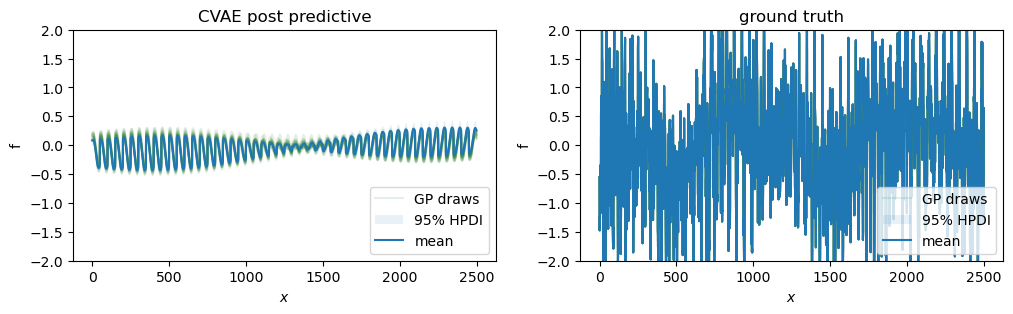

In [37]:

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)


all_ls_cvae_mcmc_samples =  run_mcmc(args["num_warmup"], args["num_samples"], args["num_chains"], rng_key_true_mcmc, cvae, args["x"], ground_truth_y_obs, obs_idx, fallback_init=False)
predictive = Predictive(cvae, all_ls_cvae_mcmc_samples)

predictions = predictive(rng_key_pred, x=args["x"], length=None)


plot_2d_draws(jnp.reshape(predictions["f"], (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D inference predictions, all LSs")

compare_draws(jnp.arange(args["n"] ** args["dim"]), predictions["f"], ground_truth_y_draw[None], "CVAE post predictive", "ground truth", "f", "f")


# Posterior of lengthscale condition

Text(0.5, 1.0, 'c - posterior samples')

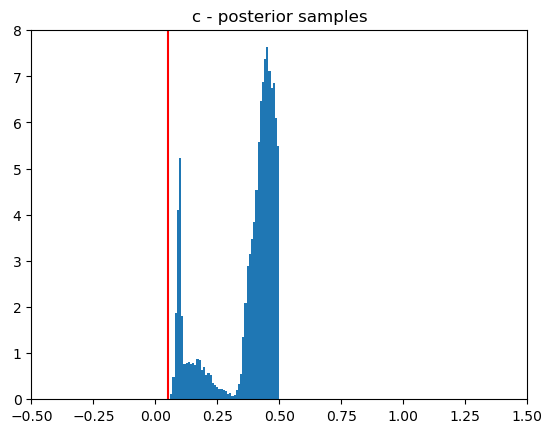

In [38]:
import matplotlib.pyplot as plt
c_samps = all_ls_cvae_mcmc_samples['c']
plt.hist(c_samps, density=True, bins=50) 
plt.xlim(-0.5,1.5)
plt.axvline(x=0.05, color="red")
plt.title('c - posterior samples')